# The regression notebook

In this notebook we perform what we described as the 'pipeline' in the paper from the CNN part down. So we'll generate all the heatmaps, perform segmentation, feature extraction, regional score computation, feature selection and finally generate the final decision tree.

In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

In [2]:
N = 1000
size = 64
labels = np.random.randint(1, size = N)
imgs = np.zeros((size, size, N))




In [3]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=4)
    elif labels[i] == 1:
        x = generator.generate_new_blob_img(ellipse=False, size=size,num_big_blobs=4)
    elif labels[i] == 2:
        x = generator.generate_new_blob_img(ellipse=False, size=size,num_big_blobs=0)
    imgs[:,:,i] = x

(-0.5, 63.5, 63.5, -0.5)

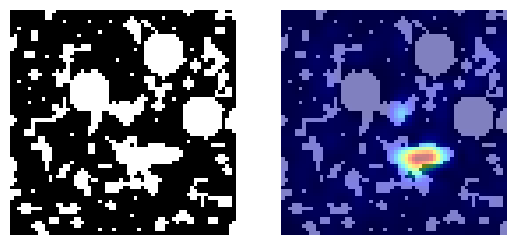

In [16]:
model = tf.keras.models.load_model("models/model40_padding")
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgs[:,:,2], cmap = 'gray')
ax[1].imshow(imgs[:,:,2], cmap = 'gray')
ax[1].imshow(GradCam(imgs[:,:,2], model, -6, 0), cmap ='jet', alpha= 0.5)
ax[0].axis('off')
ax[1].axis('off')

(-0.5, 63.5, 63.5, -0.5)

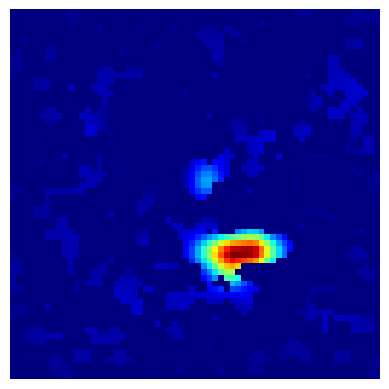

In [8]:
#visualisation of a single image after point-wise multiplication. Only serves as reminder
x = imgs[:,:,2]
xgc = GradCam(imgs[:,:,2], model, -6, 0)
plt.imshow(x*xgc, cmap = 'jet')
plt.axis('off')

In [72]:
import ipywidgets as widgets
#picker for the different CAM methods. It's best to try different ones and compare their R^2 to see which one works best.
method_picker = widgets.Dropdown(
    options=[('Grad-CAM', 0), ('Grad-CAM++', 1), ('ScoreCAM', 2), ('LayerCAM', 3)],
    value=0,
    description='Method:',
)

#pick what you want to see
display(method_picker)

Dropdown(description='Method:', options=(('Grad-CAM', 0), ('Grad-CAM++', 1), ('ScoreCAM', 2), ('LayerCAM', 3))…

In [73]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.layercam import Layercam
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
model = tf.keras.models.load_model("models/model40_padding/")

cat = CategoricalScore(0)
mod = ReplaceToLinear()
if method_picker.value == 0:
    method = Gradcam(model, model_modifier=mod, clone = True)
elif method_picker.value == 1:
    method = GradcamPlusPlus(model, model_modifier=mod, clone = True)

elif method_picker.value == 2:
    method = Scorecam(model)

elif method_picker.value == 3:
    method = Layercam(model, model_modifier=mod, clone=True)


method

In [74]:
import ipywidgets as widgets

method_picker = widgets.Dropdown(
    options=[('Grad-CAM', 0), ('Grad-CAM++', 1), ('ScoreCAM', 2), ('LayerCAM', 3)],
    value=0,
    description='Method:',
)

#pick what you want to see
display(method_picker)

Dropdown(description='Method:', options=(('Grad-CAM', 0), ('Grad-CAM++', 1), ('ScoreCAM', 2), ('LayerCAM', 3))…

In [81]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.layercam import Layercam
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
model = tf.keras.models.load_model("models/model40_padding/")
#model.layers[-1].activation = None
cat = CategoricalScore(0)
mod = ReplaceToLinear()
if method_picker.value == 0:
    method = Gradcam(model, model_modifier = mod)
elif method_picker.value == 1:
    method = GradcamPlusPlus(model, clone = True)

elif method_picker.value == 2:
    method = Scorecam(model)

elif method_picker.value == 3:
    method = Layercam(model, clone=True)


method

In [82]:
#make gradcam heatmap for every image and normalise
heatmaps = np.zeros_like(imgs)

for img in range(N):
    heatmaps[:,:,img] = method(cat, np.expand_dims(imgs[:,:,img],-1)).squeeze()
    #heatmaps[:,:,img] = GradCam(imgs[:,:,img], model, -6, 0)
    #heatmaps[:,:,img] /= 255
    #heatmaps[:,:,img] = minmax_scale(heatmaps[:,:,img])



In [74]:
#check maximum of heatmap to ensure correct implementation. Should always be 1 (approximately)
heatmaps[:,:,0].max()

0.9999999403953552

In [47]:
#get segmentation for every image
region_imgs = np.zeros_like(imgs, dtype=np.int64)

for img in range(N):
    region_imgs[:,:,img] = measure.label(imgs[:,:,img])

In [49]:
#find number of blobs in all images
num_blobs_array = []
for img in range(N):
    num_blobs_array.append(np.unique(region_imgs[:,:,img]).shape[0] - 1)

num_blobs = sum(num_blobs_array)
num_blobs

68946

In [83]:
#generate interpretability scores for each blob; score is the sum of intensities of heatmap in the region
#plus get the highest score for every image
scores = np.zeros(num_blobs)
i = 0
highscores = []
for img in range(N):
    img_highscore = 0
    for region in np.unique(region_imgs[:,:,img]):   
        if region != 0:
            x = np.copy(region_imgs[:,:,img])
            x[x != region] = 0
            x[x == region] = 1
            img_score = heatmaps[:,:,img] * x
            scores[i] = np.mean(img_score[img_score!=0])
            if scores[i] > img_highscore:
                img_highscore = scores[i]
            i += 1
    highscores.append(img_highscore)
        

/home/wph/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wph/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [84]:
#as some regions do not have nonzero heatmap regions, taking the mean results in NaNs. This replaces all the NaNs by zero
scores = np.nan_to_num(scores, nan=0)


(array([66843.,   815.,   514.,    91.]),
 array([0.        , 0.1798649 , 0.3597298 , 0.53959469, 0.71945959]),
 <BarContainer object of 4 artists>)

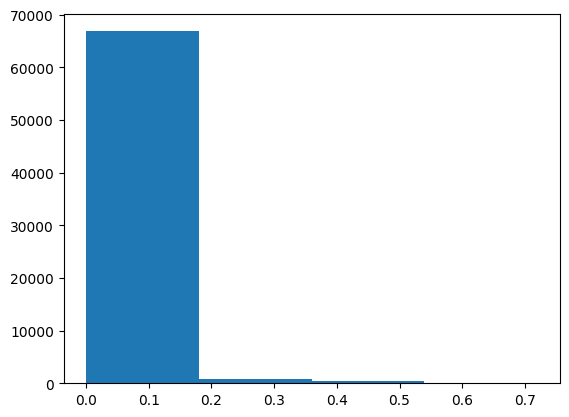

In [16]:
#small histogram to show distribution of scores
plt.hist(scores, bins=4)

In [52]:
#generate the feature arrays for different chosen features. This can probably be done more elagantly. As it stands, for every image we generate different tables,
#convert them to numpy and then append them to the respective list
blob_areas = []
blob_eccentricities = []
blob_eq_diameter = []
blob_bboxs = []
blob_major_axes = []
blob_minor_axes = []
blob_extents = []
#blob_max_intensities = []
#blob_min_intensities = []
#blob_mean_intensities = []
blob_solidities = []
for img in range(N):
    areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['area'])).to_numpy().squeeze()
    eccentricities = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['eccentricity'])).to_numpy().squeeze()
    eq_diameter = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['equivalent_diameter_area'])).to_numpy().squeeze()
    bbox = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['area_bbox'])).to_numpy().squeeze()
    major_axis = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['axis_major_length'])).to_numpy().squeeze()
    minor_axis = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['axis_minor_length'])).to_numpy().squeeze()
    extent = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['extent'])).to_numpy().squeeze()
    #intensity_max = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['intensity_max'])).to_numpy().squeeze()
    #intensity_mean = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['intensity_mean'])).to_numpy().squeeze()
    #intensity_min = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['intensity_min'])).to_numpy().squeeze()
    solidity = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['solidity'])).to_numpy().squeeze()
    blob_areas += areas.tolist()
    blob_eccentricities += eccentricities.tolist()
    blob_eq_diameter += eq_diameter.tolist()
    blob_bboxs += bbox.tolist()
    blob_major_axes += major_axis.tolist()
    blob_minor_axes += minor_axis.tolist()
    blob_extents += extent.tolist()
    #blob_max_intensities += intensity_max.tolist()
    #blob_min_intensities += intensity_min.tolist()
    #blob_mean_intensities += intensity_min.tolist()
    blob_solidities += solidity.tolist()


blob_areas = np.asarray(blob_areas)
blob_eccentricities = np.asarray(blob_eccentricities)
blob_eq_diameter = np.asarray(blob_eq_diameter)
blob_bboxs = np.asarray(blob_bboxs)
blob_major_axes = np.asarray(blob_major_axes)
blob_minor_axes = np.asarray(blob_minor_axes)
blob_extents = np.asarray(blob_extents)
#blob_max_intensities = np.asarray(blob_max_intensities)
#blob_min_intensities = np.asarray(blob_min_intensities)
#blob_mean_intensities = np.asarray(blob_mean_intensities)
blob_solidities = np.asarray(blob_solidities)

blob_areas.shape

(68946,)

In [85]:
#prepare data for training. this is the 'naive' decision tree using all features
from sklearn.model_selection import train_test_split
X = np.vstack((blob_eccentricities, blob_areas, blob_eq_diameter, blob_bboxs, blob_extents, blob_major_axes, blob_minor_axes, blob_solidities))

# X = np.vstack((blob_major_axes, blob_minor_axes))

X = np.transpose(X)
y = scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)





In [78]:
#build regression tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=2)
regressor = regressor.fit(X_train, y_train)

In [18]:
#r^2 of the regressor. This value is typically going to be low as it's a shallow tree
regressor.score(X_test, y_test)

0.23874320804758165

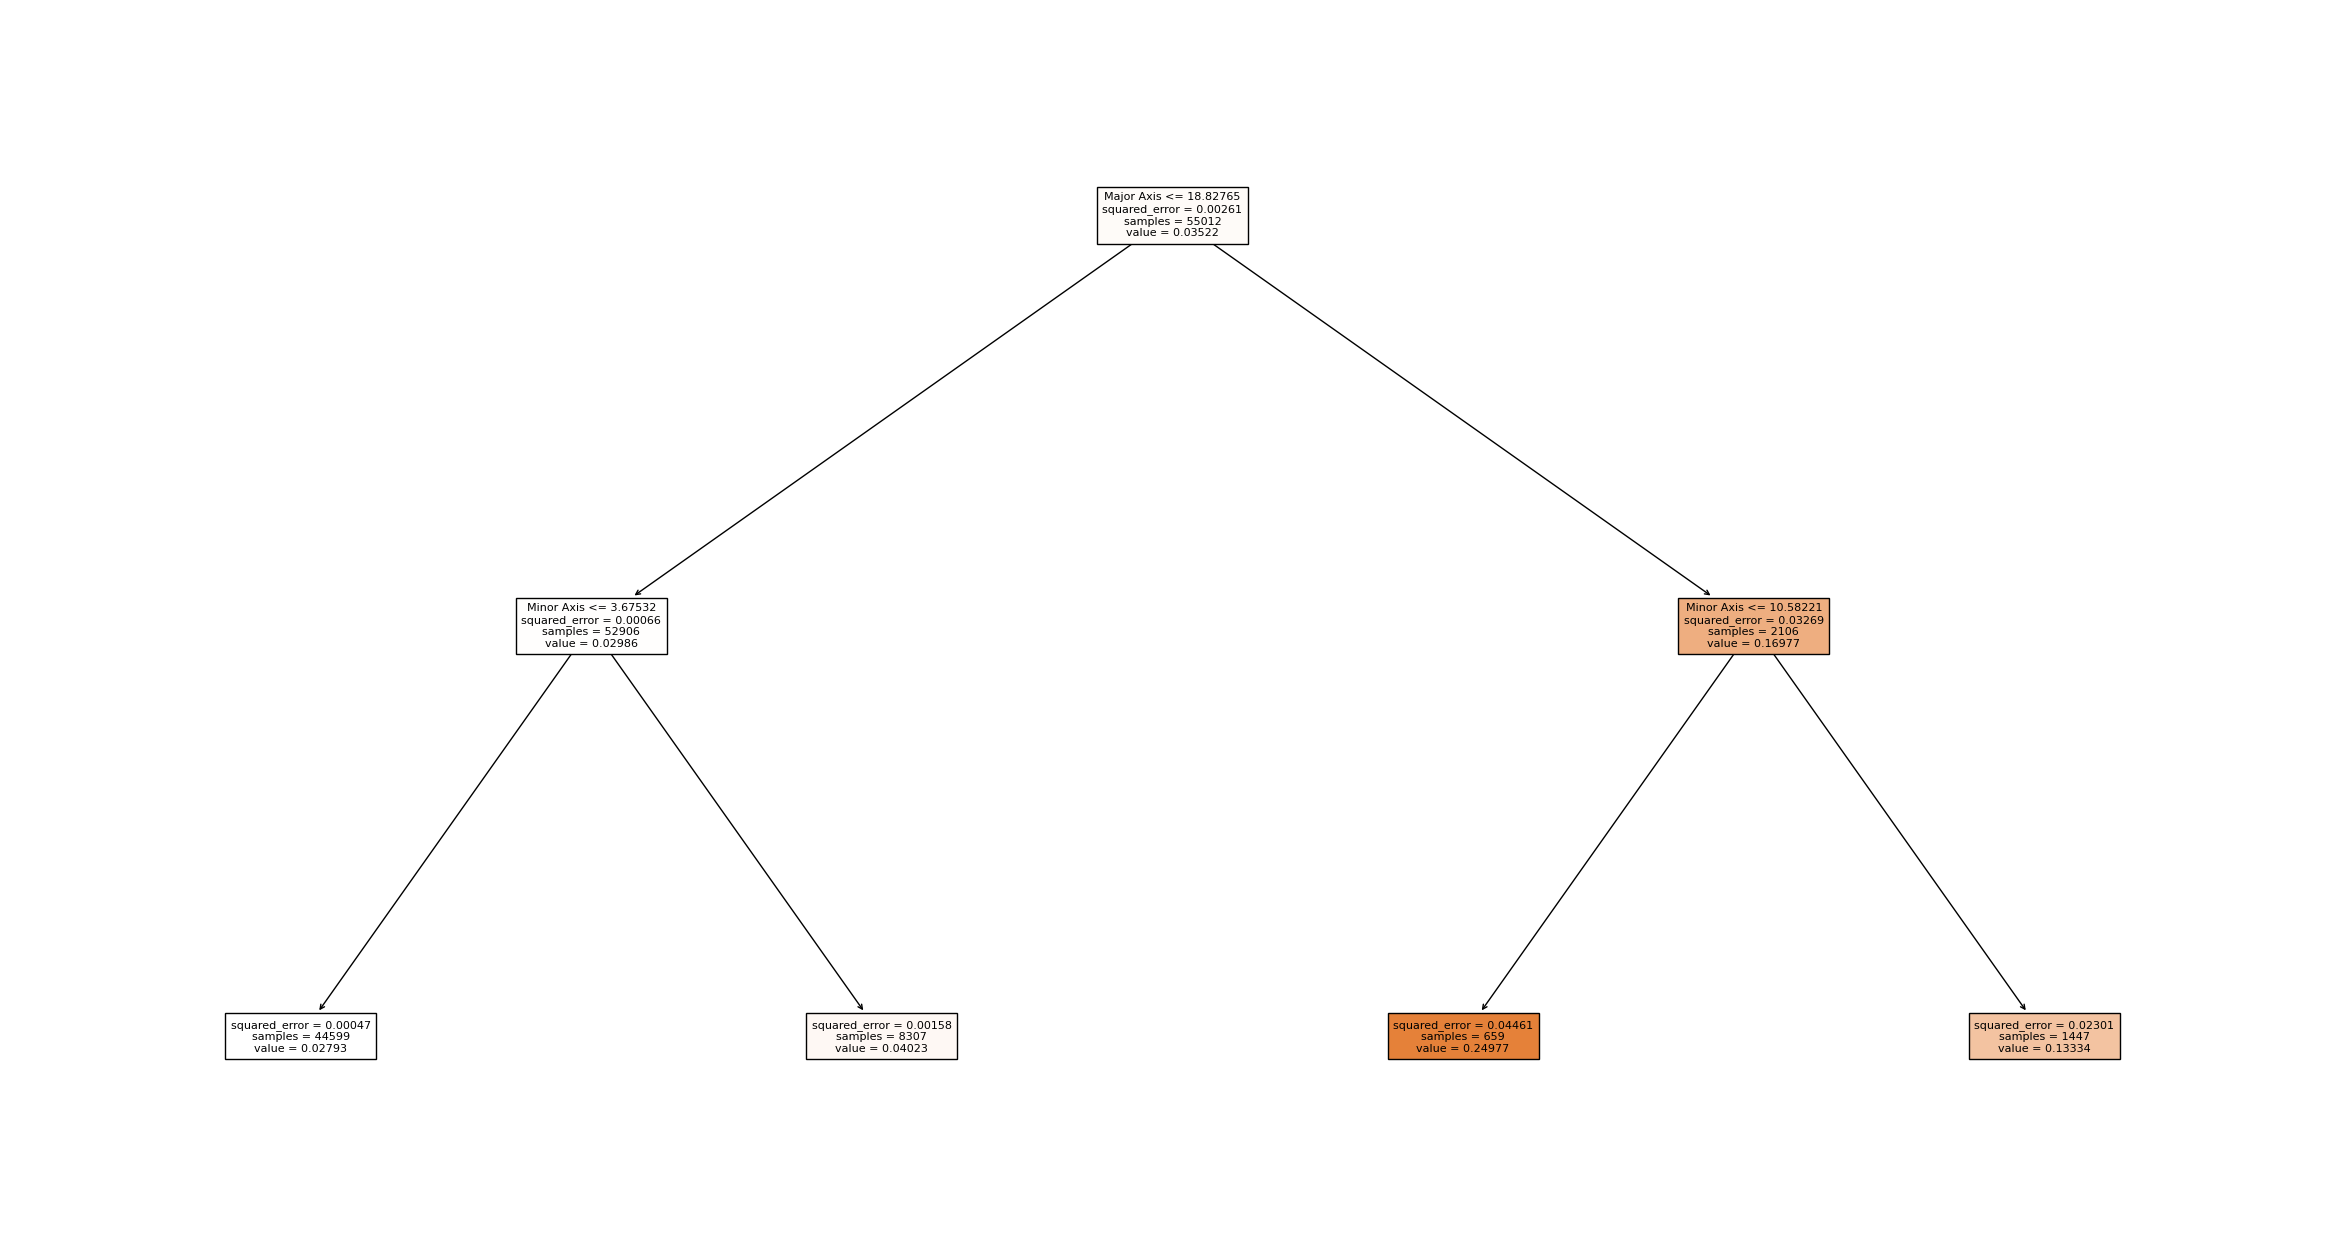

In [71]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,16))
# plot_tree(regressor, max_depth=2, feature_names=['Eccentricity', 'Area', 'Equivalent Diameter', 'Bounding Box Area', 'Extent', 'Major Axis', 'Minor Axis', 'Solidity'], filled=True, fontsize=8, precision=5)
plot_tree(regressor, max_depth=2, feature_names=['Major Axis', 'Minor Axis'], filled=True, fontsize=8, precision=5)

plt.show()


In [86]:
from sklearn.ensemble import RandomForestRegressor
#the random forest regressor
feature_names = ['Eccentricity', 'Area', 'Equivalent Diameter', 'Bounding Box Area', 'Extent', 'Major Axis', 'Minor Axis', 'Solidity']
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [87]:
#r^2 for the random forest regressor. This is the relevant r^2 value to determine how well the method works on the data. Varies greatly depending on the visual method used
forest.score(X_test, y_test)

0.5106183609690781

In [21]:
from sklearn.inspection import permutation_importance
#permutation importance analysis
result = permutation_importance(forest, X_test, y_test, n_repeats = 10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

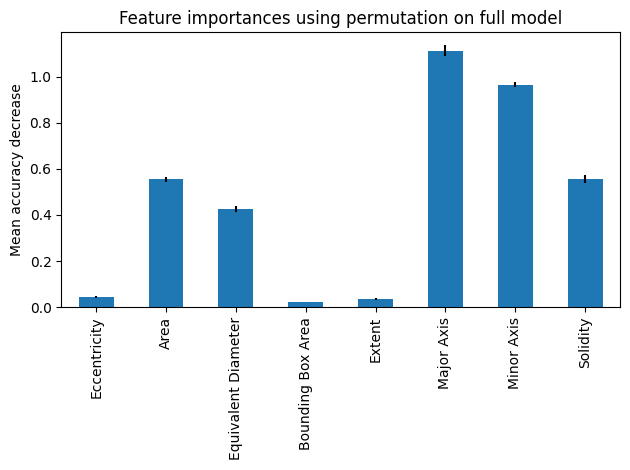

In [22]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
#after doing the feature importance analysis, build the tree again, but only with the most important features
X = np.vstack((blob_major_axes, blob_minor_axes))

X = np.transpose(X)
y = scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)